This notebook was written to streamline the process of searching with HHBlits to find FsxA using an HMM and compare HMMs in an all vs all fashion. We first use an HMM to search for unannotated homologues of Hap2 and then use a curated set of Fusexin sequences to seed HMMs and perform an all vs all comparison.

In [1]:
import subprocess
import shlex

In [4]:
import csb

In [5]:
import subprocess as sp, shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ''):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.hhm'
        args += ' -ohhm ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]


def runHHmake( aln , name, path = 'hhmake' , outdir='./', verbose = False, SS = False):
    if verbose == True:
        print( [aln , name, path , outdir] )
    outhhm= outdir+name+".hhm"
    args = path + ' -i '+  aln  +' -o '+ outhhm + ' -M 50'
    if SS == True:
        #todo : make ss prediction here
        pass
    args = shlex.split(args)
    print(args)
    
    p = subprocess.Popen(args )
    return p , [outhhm]

    

def hhrparse(hhr , coverage , proba ):
    profile = HHOutputParser(alignments=False).parse_file(hhr)
    qname = profile.query_name
    for hit in profile:
        proba = hit.probability
        i = hit.id


In [6]:
#use struct align to find FSXA
#check with interpro Hap2 list for new entries
import urllib.parse
import urllib.request
from io import StringIO
import pandas as pd

def unirequest_tab(q):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uniprot/'
    params = {
    'columns': 'id,entry name,reviewed,protein names,genes,organism,length',
    'format': 'tab',
    'query':q
    }
    
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return r    
q= 'database:(type:interpro hap2/gcs1)'
Hapdf = pd.read_table( StringIO(unirequest_tab(q)))
print(Hapdf)
#align FSXA and check struct

          Entry        Entry name      Status  \
0        A4GRC6        HAP2_CHLRE    reviewed   
1        B9G4M9       HAP2B_ORYSJ    reviewed   
2    A0A060A682        HAP2_TETTH    reviewed   
3        Q4YCF6        HAP2_PLABA    reviewed   
4        A7SIM4        HAP2_NEMVE    reviewed   
..          ...               ...         ...   
850      F0ZW03      F0ZW03_DICPU  unreviewed   
851  A0A1X0P0J5  A0A1X0P0J5_9TRYP  unreviewed   
852  A0A6A5CAY9  A0A6A5CAY9_NAEFO  unreviewed   
853  A0A1C6YIB4  A0A1C6YIB4_PLACH  unreviewed   
854  A0A640KS21  A0A640KS21_LEITA  unreviewed   

                                     Protein names  \
0    Hapless 2 (HAP2) (Generative cell specific-1)   
1                              Protein HAPLESS 2-B   
2           Hapless 2 (Generative cell specific-1)   
3           Hapless 2 (Generative cell specific-1)   
4           Hapless 2 (Generative cell specific 1)   
..                                             ...   
850            HAP2-GCS1 domain-c

In [7]:
#lets search for new Hap2 homologues using the structurally guided MSA of just Hap2 structures
import time
t0 = time.time()
structaln ='./structalnHap2.fasta'
p, output = runHHmake( structaln , 'structaln' , path = 'hhmake' , outdir='./', verbose = False, SS = False)

uniclust = '/home/cactuskid13/mntpt/HHBLITsdb/uniclust30_2018_08/uniclust30_2018_08'
p , output = runHHblits( output[0] , name = 'structaln' , path= 'hhblits ' , outdir = './' , db = uniclust , iterations= 3 , ncores = 28 , verbose = True , runName= 'findFsxA'  , xargs = ' -mact .5 ')
print( time.time() - t0)

['hhmake', '-i', './structalnHap2.fasta', '-o', './structaln.hhm', '-M', '50']


FileNotFoundError: [Errno 2] No such file or directory: 'hhmake'

In [10]:
#Any Hap2 homologues that don't have a PFAM domain might be worth considering as unknown fusexins
from csb.bio.io.hhpred import HHOutputParser
haps = set(Hapdf.Entry)
newhits = {}
results = HHOutputParser(alignments=False).parse_file(output[0])
for hit in results:
    if hit.id.split('|')[1].strip() not in haps:
        newhits.update( { hit.id.split('|')[1].strip() : { 'prob':hit.probability, 'len' : hit.length }}  )

NameError: name 'output' is not defined

In [ ]:
import bioservices
#lets pull all the new hits from uniprot
uni = bioservices.uniprot.UniProt()
df = uni.get_df( newhits.keys() )

In [19]:
#we can assign an HHblits score to each hit
#adhoc score = len * proba
hhdf = pd.DataFrame.from_dict( newhits , orient = 'index')
df = df.merge( hhdf, how = 'left' , left_on = 'Entry' , right_index = True )
df['score'] = df['prob'] * df['len']
#sort the DF and print
print(df.sort_values( 'score' , ascending = False) )
#woohooo we have some nice hits in archaea!

NameError: name 'df' is not defined

In [20]:
#after playing around with these hits we found some viable candidates 
#we called these fsxa
# now we can start comparing known fusexins to fsxa
# we have a hand compiled list of fusexin ecto domain wed like to compare

from Bio import SeqIO
parsed = SeqIO.parse( './queries_all.fasta' , 'fasta')
for seq in parsed:
    ID = seq.description.split(' ')[-1].replace('(' , '').replace( ')' , '')
    seq.id = ID
    seq.name = ''
    seq.description = ''
    
    print(seq)
    SeqIO.write( seq,  './queries/' + ID + '.fasta' , 'fasta' )
    

ID: P12823
Number of features: 0
Seq('MRCIGISNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELIKTEAKQPA...FGA', SingleLetterAlphabet())
ID: P14336
Number of features: 0
Seq('SRCTHLENRDFVTGTQGTTRVTLVLELGGCVTITAEGKPSMDVWLDAIYQENPA...AFN', SingleLetterAlphabet())
ID: Q89292
Number of features: 0
Seq('AHCIGITDRDFIEGVHGGTWVSATLEQDKCVTVMAPDKPSLDISLQTVAIDGPA...AFQ', SingleLetterAlphabet())
ID: P03315
Number of features: 0
Seq('YEHSTVMPNVVGFPYKAHIERPGYSPLTLQMQVVETSLEPTLNLEYITCEYKTV...ISG', SingleLetterAlphabet())
ID: Q1H8W5
Number of features: 0
Seq('YEHVTVIPNTVGVPYKTLVNRPGYSPMVLEMELLSVTLEPTLSLDYITCEYKTV...VQK', SingleLetterAlphabet())
ID: P08563
Number of features: 0
Seq('EEAFTYLCTAPGCATQTPVPVRLAGVRFESKIVDGGCFAPWDLEATGACICEIP...AAH', SingleLetterAlphabet())
ID: P08668
Number of features: 0
Seq('SETPLTPVWNDNAHGVGSVPMHTDLELDFSLTSSSKYTYRRKLTNPLEEAQSID...SGN', SingleLetterAlphabet())
ID: P03518
Number of features: 0
Seq('CSELIQASSRITTCSTEGVNTKCRLSGTALIRAGSVGAEACLMLKGVKEDQTKF...NPK', SingleLetterAlphabet())


In [21]:
#generate profiles for each fusexin
import glob
import os

try:
    os.mkdir('HHM_UNI')
except:
    pass
queries = glob.glob('queries/*.fasta')

outdir = './HHM_UNI/'
done = glob.glob(outdir+'*hhm')

print(done)
print(queries)
for q in queries:
    name =  q.split('.')[0].split('/')[1] + 'Profphylo'
    runName= 'test'
    outa3m = outdir+name+runName+'.hhm'
    if outa3m not in done:
        p,output = runHHblits(q , name = name, path= 'hhblits ' , outdir = outdir , db = uniclust , iterations= 3 , ncores = 28 , ohhm = True, verbose = True , runName= runName , xargs = ' -mact .5')    

['./HHM_UNI/RLG58774Profphylotest.hhm', './HHM_UNI/Q89292Profphylotest.hhm', './HHM_UNI/A4GRC6Profphylotest.hhm', './HHM_UNI/P08563Profphylotest.hhm', './HHM_UNI/A0A1X7UDL0Profphylotest.hhm', './HHM_UNI/P12823Profphylotest.hhm', './HHM_UNI/P03315Profphylotest.hhm', './HHM_UNI/T1ISJ2Profphylotest.hhm', './HHM_UNI/A0A0D2WS34Profphylotest.hhm', './HHM_UNI/A0A5J4UPK0Profphylotest.hhm', './HHM_UNI/WP_058826362Profphylotest.hhm', './HHM_UNI/A3FEQ2Profphylotest.hhm', './HHM_UNI/F4JP36Profphylotest.hhm', './HHM_UNI/A0A060A682Profphylotest.hhm', './HHM_UNI/RLI53188Profphylotest.hhm', './HHM_UNI/P03518Profphylotest.hhm', './HHM_UNI/R7UM94Profphylotest.hhm', './HHM_UNI/D2VN83Profphylotest.hhm', './HHM_UNI/A9V179Profphylotest.hhm', './HHM_UNI/A0A0K2SR10Profphylotest.hhm', './HHM_UNI/A0A0K0VK49Profphylotest.hhm', './HHM_UNI/CRY7J9Profphylotest.hhm', './HHM_UNI/Q4DKJ2Profphylotest.hhm', './HHM_UNI/P14336Profphylotest.hhm', './HHM_UNI/G5ECA1Profphylotest.hhm', './HHM_UNI/FsxAEProfphylotest.hhm', './H

In [22]:
#run all v all comparison
hhms = glob.glob( 'HHM_UNI/*.hhm')
with open( 'hhsearch.pal' , 'w') as palfile:
    for hhm in hhms:
        palfile.write( hhm + '\n')

try:
    os.mkdir('ALLVSALL')
except:
    pass

print(hhms)
for q in hhms:
    p,output = runHHblits(q , name = q.split('.')[0].split('/')[1] + 'allvall' , path= 'hhsuite2/bin/hhsearch' , outdir = 'ALLVSALL/' , db = './hhsearch.pal' , iterations= 1 , ncores = 8 , ohhm = False, verbose = True , runName= 'test' , xargs = ' -mact .5')

['HHM_UNI/RLG58774Profphylotest.hhm', 'HHM_UNI/Q89292Profphylotest.hhm', 'HHM_UNI/A4GRC6Profphylotest.hhm', 'HHM_UNI/P08563Profphylotest.hhm', 'HHM_UNI/A0A1X7UDL0Profphylotest.hhm', 'HHM_UNI/P12823Profphylotest.hhm', 'HHM_UNI/P03315Profphylotest.hhm', 'HHM_UNI/T1ISJ2Profphylotest.hhm', 'HHM_UNI/A0A0D2WS34Profphylotest.hhm', 'HHM_UNI/A0A5J4UPK0Profphylotest.hhm', 'HHM_UNI/WP_058826362Profphylotest.hhm', 'HHM_UNI/A3FEQ2Profphylotest.hhm', 'HHM_UNI/F4JP36Profphylotest.hhm', 'HHM_UNI/A0A060A682Profphylotest.hhm', 'HHM_UNI/RLI53188Profphylotest.hhm', 'HHM_UNI/P03518Profphylotest.hhm', 'HHM_UNI/R7UM94Profphylotest.hhm', 'HHM_UNI/D2VN83Profphylotest.hhm', 'HHM_UNI/A9V179Profphylotest.hhm', 'HHM_UNI/A0A0K2SR10Profphylotest.hhm', 'HHM_UNI/A0A0K0VK49Profphylotest.hhm', 'HHM_UNI/CRY7J9Profphylotest.hhm', 'HHM_UNI/Q4DKJ2Profphylotest.hhm', 'HHM_UNI/P14336Profphylotest.hhm', 'HHM_UNI/G5ECA1Profphylotest.hhm', 'HHM_UNI/FsxAEProfphylotest.hhm', 'HHM_UNI/HGF63239Profphylotest.hhm', 'HHM_UNI/M1V8A6Prof

In [10]:
#parse hhr files and make dist kernel
#use Fastme to make a tree

import numpy as np
import networkx as nx
import os
import glob
from csb.bio.io.hhpred import HHOutputParser
import subprocess , shlex
import pickle
import tempfile
from ete3 import PhyloTree
import seaborn as sns

def runFastme( fastmepath , clusterfile ):
    args =  fastmepath +  ' -i ' + clusterfile + ' -o ' + clusterfile+'_tree.txt'
    print( args)
    p = subprocess.call(shlex.split(args) , stdout=subprocess.PIPE )
    return p,[clusterfile+'_tree.txt' ]

def distmat_to_txt( namelist , distmat, filedir , name):
    print( namelist)
    print( distmat.shape)
    outstr = str(len(pdblist)) + '\n'
    for i,pdb in enumerate(namelist):
        namestr = pdb[0:20]
        outstr += namestr+ ' ' + np.array2string( distmat[i,:], formatter={'float_kind':lambda x: "%.2f" % x} , precision = 8 ).replace('[', '').replace(']', '').replace('\n', '' )  + '\n'
    with open(filedir + name + 'fastmemat.txt' , 'w') as handle:
        handle.write(outstr)
    return filedir + name + 'fastmemat.txt' , filedir + name + 'phylipmat.txt'

def cleanID(ID):
    
    if '|PDBID' in ID:
        ID = ID.split('|PDBID')[0]
    
    if '|' in ID:
        ID = ID.split('|')[1]
    if '.' in ID:
        ID = ID.split('.')[0]
    if '/' in ID:
        ID = ID.split('/')[0]
    if 'hmmercut' in ID:
        ID = ID.split('hmmercut')[0]
    ID = ID.strip()
    return ID


def HHSearch_parseTo_DMandNX(hhrs ):
    clusternames = []
        
    for i,hhr in enumerate(hhrs):
        profile = HHOutputParser(alignments=False).parse_file(hhr)
        if profile.query_name not in clusternames:
            clusternames.append(cleanID(profile.query_name))
    print(clusternames)
    evalDM = np.ones( (len(clusternames),len(clusternames) ))
    pvalDM = np.ones( (len(clusternames),len(clusternames) ))
    scoreDM = np.zeros( (len(clusternames),len(clusternames) ))
    SSDM = np.zeros( (len(clusternames),len(clusternames) ))
    probaDM = np.zeros( (len(clusternames),len(clusternames) ))
    lenDM =  np.ones( (len(clusternames),len(clusternames) ))
    
    NX = nx.Graph()
    
    for i,hhr in enumerate(hhrs):
        protlist = []
        profile = HHOutputParser(alignments=False).parse_file(hhr)
        for hit in profile:
            DMscore = float(hit.evalue)
            proba = hit.probability
            if 'anchor' not in hit.id and 'anchor' not in profile.query_name:
                i = clusternames.index(cleanID(hit.id))
                j = clusternames.index(cleanID(profile.query_name))

                if hit.evalue < evalDM[i,j]:
                    evalDM[i,j] = hit.evalue
                    evalDM[j,i] = evalDM[i,j]

                if hit.pvalue < pvalDM[i,j]:
                    pvalDM[i,j] = hit.pvalue
                    pvalDM[j,i] = pvalDM[i,j]

                if scoreDM[i,j] < hit.score:
                    scoreDM[i,j] = hit.score
                    scoreDM[j,i] = scoreDM[i,j]

                if SSDM[i,j] < hit.ss_score:
                    SSDM[i,j] = hit.ss_score
                    SSDM[j,i] = SSDM[i,j]


                if probaDM[i,j] < hit.probability:
                    probaDM[i,j] = hit.probability
                    probaDM[j,i] = probaDM[i,j]

                #use smallest of the two prots
                if lenDM[i,j] == 1 or lenDM[i,j] > hit.qlength:
                    lenDM[i,j] = hit.qlength
                    lenDM[j,i] = lenDM[i,j]

            if hit.id != profile.query_name :
                NX.add_edge( hit.id , profile.query_name )
                NX[hit.id][profile.query_name]['score']= hit.score
    return probaDM, evalDM ,pvalDM,  lenDM , scoreDM, SSDM, NX , clusternames


['./ALLVSALL/A0A1X7UDL0Profphylotestallvalltest.hhr', './ALLVSALL/HGF63239Profphylotestallvalltest.hhr', './ALLVSALL/RLG58774Profphylotestallvalltest.hhr', './ALLVSALL/T1ISJ2Profphylotestallvalltest.hhr', './ALLVSALL/Q4DKJ2Profphylotestallvalltest.hhr', './ALLVSALL/A0A060A682Profphylotestallvalltest.hhr', './ALLVSALL/G5ECA1Profphylotestallvalltest.hhr', './ALLVSALL/P14336Profphylotestallvalltest.hhr', './ALLVSALL/Q89292Profphylotestallvalltest.hhr', './ALLVSALL/P12823Profphylotestallvalltest.hhr', './ALLVSALL/D2VN83Profphylotestallvalltest.hhr', './ALLVSALL/M1V8A6Profphylotestallvalltest.hhr', './ALLVSALL/Q1H8W5Profphylotestallvalltest.hhr', './ALLVSALL/P08668Profphylotestallvalltest.hhr', './ALLVSALL/R7UM94Profphylotestallvalltest.hhr', './ALLVSALL/P03315Profphylotestallvalltest.hhr', './ALLVSALL/A0A0K0VK49Profphylotestallvalltest.hhr', './ALLVSALL/WP_058826362Profphylotestallvalltest.hhr', './ALLVSALL/A0A0D2WS34Profphylotestallvalltest.hhr', './ALLVSALL/A0A0K2SR10Profphylotestallvall

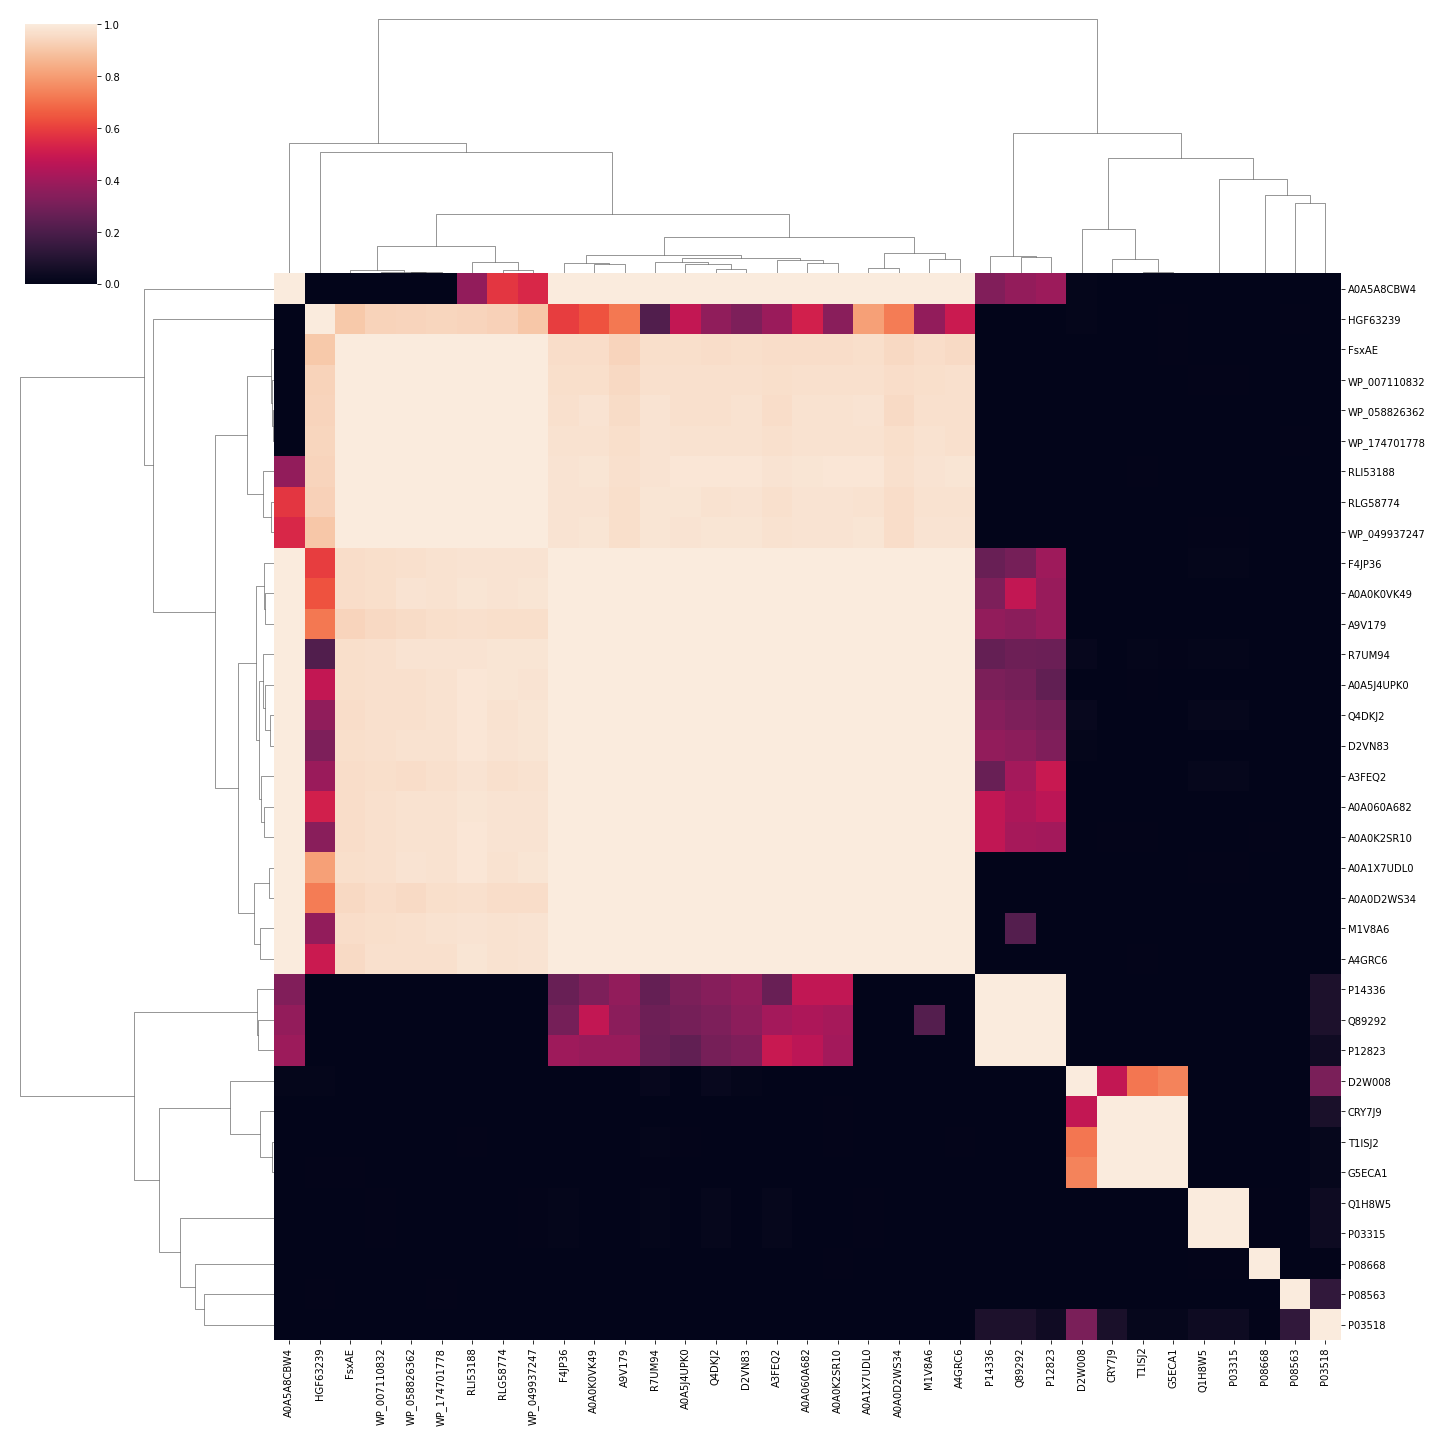

In [11]:
import seaborn as sns
import glob
print(glob.glob('./ALLVSALL/*.hhr'))
probaDM, evalDM ,pvalDM,  lenDM , scoreDM, SSDM, NX , clusternames = HHSearch_parseTo_DMandNX(glob.glob('./ALLVSALL/*.hhr'))

g = sns.clustermap( probaDM , xticklabels=clusternames  , yticklabels=clusternames , figsize = (20,20) )

In [12]:
q = 'id: F4JP36 OR H2AM12 OR G5EGL9 '
q = 'id:'+' OR '.join(clusternames)
print(q)
Hapdf = pd.read_table( StringIO(unirequest_tab(q)) )
print( Hapdf)

id:A0A1X7UDL0 OR HGF63239 OR RLG58774 OR T1ISJ2 OR Q4DKJ2 OR A0A060A682 OR G5ECA1 OR P14336 OR Q89292 OR P12823 OR D2VN83 OR M1V8A6 OR Q1H8W5 OR P08668 OR R7UM94 OR P03315 OR A0A0K0VK49 OR WP_058826362 OR A0A0D2WS34 OR A0A0K2SR10 OR F4JP36 OR CRY7J9 OR A9V179 OR A4GRC6 OR WP_174701778 OR D2W008 OR A3FEQ2 OR RLI53188 OR A0A5J4UPK0 OR P08563 OR WP_007110832 OR A0A5A8CBW4 OR FsxAE OR P03518 OR WP_049937247
         Entry        Entry name      Status  \
0       Q8IWU4        ZNT8_HUMAN    reviewed   
1       Q07021       C1QBP_HUMAN    reviewed   
2       P46091        CML2_HUMAN    reviewed   
3       A4GRC6        HAP2_CHLRE    reviewed   
4   A0A060A682        HAP2_TETTH    reviewed   
5       P08668          GP_HANTV    reviewed   
6       F4JP36        HAP2_ARATH    reviewed   
7       P03518           GP_RVFV    reviewed   
8       P03315          POLS_SFV    reviewed   
9       Q9Y6H1       CHCH2_HUMAN    reviewed   
10      P08563        POLS_RUBVM    reviewed   
11      P14336   

In [13]:
organisms = dict( zip ( Hapdf.Entry , Hapdf.Organism ) )

manual = { 'RKZ11204':'Candidatus Fermentibacteria bacterium'  , 'RLG94066' : 'Candidatus Bathyarchaeota archaeon' 
          , 'WP_007110832':'Natrinema altunense' , 'RKX41251': 'Thermotogae bacterium', 'WP_058826362':'Haloferax sp. Q22' , 'RLI53188' : 'Candidatus Thorarchaeota archaeon' ,
          'RLG58774':'Candidatus Geothermarchaeota archaeon' , 'WP_049937247': 'Haloplanus natans'  
          , '1RER:A':'Semliki Forest virus'  , '5G47:A': 'Severe fever with thrombocytopenia syndrome virus' , 'GP_BUNL8':'La Crosse virus', '9790312':'Rubella virus',
          'A3RKP6_9VIRU':'Puumala orthohantavirus' , 'CRY7J9':'Branchiostoma floridae'  , 'WP_174701778':'Haloterrigena sp.' , 'Cand. Geothermarchaeota':'RLG58774' ,
          'HGF63239':'Cand. Micrarchaeota archaeon'
         }
organisms.update(manual)

In [14]:
#subsample

"""Dengue-2 E 1OK8 (P12823, 281 – 775)   

SFV E1 1RER (P03315, 816 – 1253) 

Rubella E1 4B3V (P08563, 583 – 1063)

RVFV Gc 4HJ1  (P03518, 691 – 1206)

Arabidopsis thaliana 5OW3 (F4JP36, 25 – 561)

Chlamydomonas reinhardtii 6E18 (A4GRC6, 23 – 630)

Trypanosoma cruzi 5OW4 (Q4DKJ2, 21 – 588)

Caenorhabditis elegans EFF-1 4CYL (G5ECA1, 23-555)
Haloferax sp Q22 WP_058826362 
Natrinema altunense WP_144240185
"""

include_list = ['P12823' , 'P08563', 'P03518' , 'F4JP36' , 'A4GRC6'  , 'Q4DKJ2' , 'G5ECA1'  ,'WP_058826362' , 'FsxAE' , 'WP_007110832'  ]
index = []
filtername = []
clusternamesWorga = [ c +' ' + organisms[c] if c in organisms else c for c in clusternames]

print(clusternamesWorga)

for i, name in enumerate(clusternamesWorga):
    for ID in include_list:
        if ID in name:
            print(name)
            filtername.append(name)
            index.append(i)


"""
VIRAL FUSEXINS:

ssRNA positive: 

Flaviviridae/Flavivirus:

- Dengue-2 E 1OK8 (P12823, 281 – 775)   

- TBEV E 1SVB (P14336, 281 – 776)

- Yellow fever Virus E 6IVZ (Q89292, 1-444)

Togaviridae/Alphavirus:

- SFV E1 1RER (P03315, 816 – 1253) 

- Chikungunya E1 3N41 (Q1H8W5, 810-1222)

Matornaviridae/Rubivirus:

- Rubella E1 4B3V (P08563, 583 – 1063)  what is  the same as 9790312 (583 – 1063) )

  

ssRNA negative:

 Bunyavirales:

 - Phenuviridae/Phlebovirus, RVFV Gc 4HJ1  (P03518, 691 – 1206)

- Hantaviridae/Orthohantavirus, Hantann virus Gc 5LK1 (P08668, 649 – 1105)


HAP2/GCS1:

- Viridiplantae/Streptophyta, Arabidopsis thaliana 5OW3 (F4JP36, 25 – 561)

- Viridiplantae/Chlorophyta, Chlamydomonas reinhardtii 6E18 (A4GRC6, 23 – 630)

- Rhodophyta/Bangiophyceae, Cyanidioschyzon merolae (M1V8A6, 51 – 613)

- Discoba/Euglenozoa/kinetoplastida, Trypanosoma cruzi 5OW4 (Q4DKJ2, 21 – 588)

- Opisthokonta/Choanoflagellida, Monosiga brevicollis (A9V179, 42-592)

- Opisthokonta/Filasterea, Capsaspora owczarzaki (A0A0D2WS34, 27-862)

- Opisthokonta/Metazoa/Porifera, Amphimedon queenslandica (A0A1X7UDL0, 22-642)

- Opisthokonta/Metazoa/Cnidaria, Hydra vulgaris (A3FEQ2, 30-638)

- Opisthokonta/Metazoa/Lophotrochozoa/Annelida, Capitella teleta (R7UM94, 24-544)

- Malawimonadidae, Malawimonas californiana (A0A0K0VK49, 27-554)

- Discoba/Heterolobosea, Naegleria gruberi (D2VN83, 10-479)

- Metamonada/Preaxostyla, Streblomastix strix (A0A5J4UPK0, 10-524)

- Amoebozoa/Evosea, Dictyostelium discoideum (A0A0K2SR10, 26-525)

- SAR/Stramenopiles, Cafeteria roenbergensis (A0A5A8CBW4, 20-397)

-SAR/Alveolata/Ciliophora, Tetrahymena thermophila (A0A060A682, 20 – 540)


EFF.1/AFF-1

- Metazoa/Ecdysozoa/Nematoda, Caenorhabditis elegans EFF-1 4CYL (G5ECA1, 23-555)

- Discoba/Heterolobosea, Naegleria gruberi FF (D2W008, 27-657)

- Metazoa/Chordata/Cephalochordata, Branchiostoma floridae FF (C3Y7J9, 19-532)

- Metazoa/Arthropoda, Strigamia maritima FF (T1ISJ2, 10-486)


"""


            
biginclude = [ 'P12823' , 'P14336' ,  'Q89292' , 'FsxAE' , 'P03315' , 'Q1H8W5' , 'P08563' , 'P03518' , 'P08668', 'F4JP36' , 'A4GRC6' , 'M1V8A6' , 'Q4DKJ2' , 'A9V179' , 'A0A0D2WS34' , 'A0A1X7UDL0' , 'A3FEQ2' ,
             'R7UM94' , 'A0A0K0VK49' , 'D2VN83', 'A0A5J4UPK0' , 'A0A0K2SR10', 'A0A5A8CBW4', 'A0A060A682' , 'G5ECA1' ,  'D2W008' , 'C3Y7J9' ,  'T1ISJ2' ,
           'WP_007110832', 'WP_058826362', 'RLI53188','WP_049937247', 'CRY7J9' , 'WP_174701778' , 'RLG58774'  , 'HGF63239' ]

print('---------------big list --------------------')
bigindex = []
bigfiltername = []
for i, name in enumerate(clusternamesWorga):
    for ID in biginclude:
        if ID in name:
            print(name)
            bigfiltername.append(name)
            bigindex.append(i)



['A0A1X7UDL0 Amphimedon queenslandica (Sponge)', 'HGF63239 Cand. Micrarchaeota archaeon', 'RLG58774 Candidatus Geothermarchaeota archaeon', 'T1ISJ2 Strigamia maritima (European centipede) (Geophilus maritimus)', 'Q4DKJ2 Trypanosoma cruzi (strain CL Brener)', 'A0A060A682 Tetrahymena thermophila', 'G5ECA1 Caenorhabditis elegans', 'P14336 Tick-borne encephalitis virus European subtype (strain Neudoerfl) (NEUV) (Neudoerfl virus)', 'Q89292 Yellow fever virus', 'P12823 Dengue virus type 2 (strain Puerto Rico/PR159-S1/1969) (DENV-2)', 'D2VN83 Naegleria gruberi (Amoeba)', 'M1V8A6 Cyanidioschyzon merolae (strain 10D) (Red alga)', 'Q1H8W5 Chikungunya virus (CHIKV)', 'P08668 Hantaan virus (strain 76-118) (Korean hemorrhagic fever virus)', 'R7UM94 Capitella teleta (Polychaete worm)', 'P03315 Semliki forest virus (SFV)', 'A0A0K0VK49 Malawimonas californiana (Flagellated protozoan)', 'WP_058826362 Haloferax sp. Q22', 'A0A0D2WS34 Capsaspora owczarzaki (strain ATCC 30864)', 'A0A0K2SR10 Dictyostelium d

single


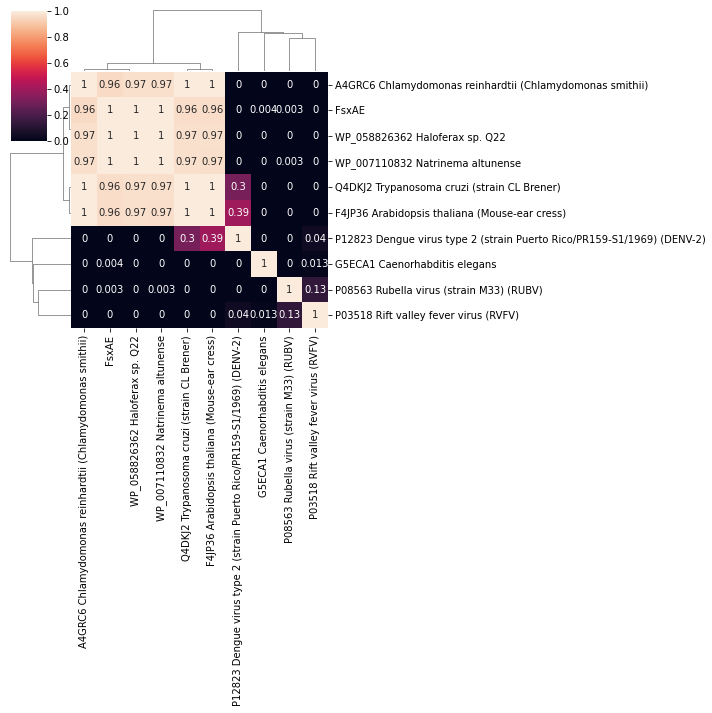

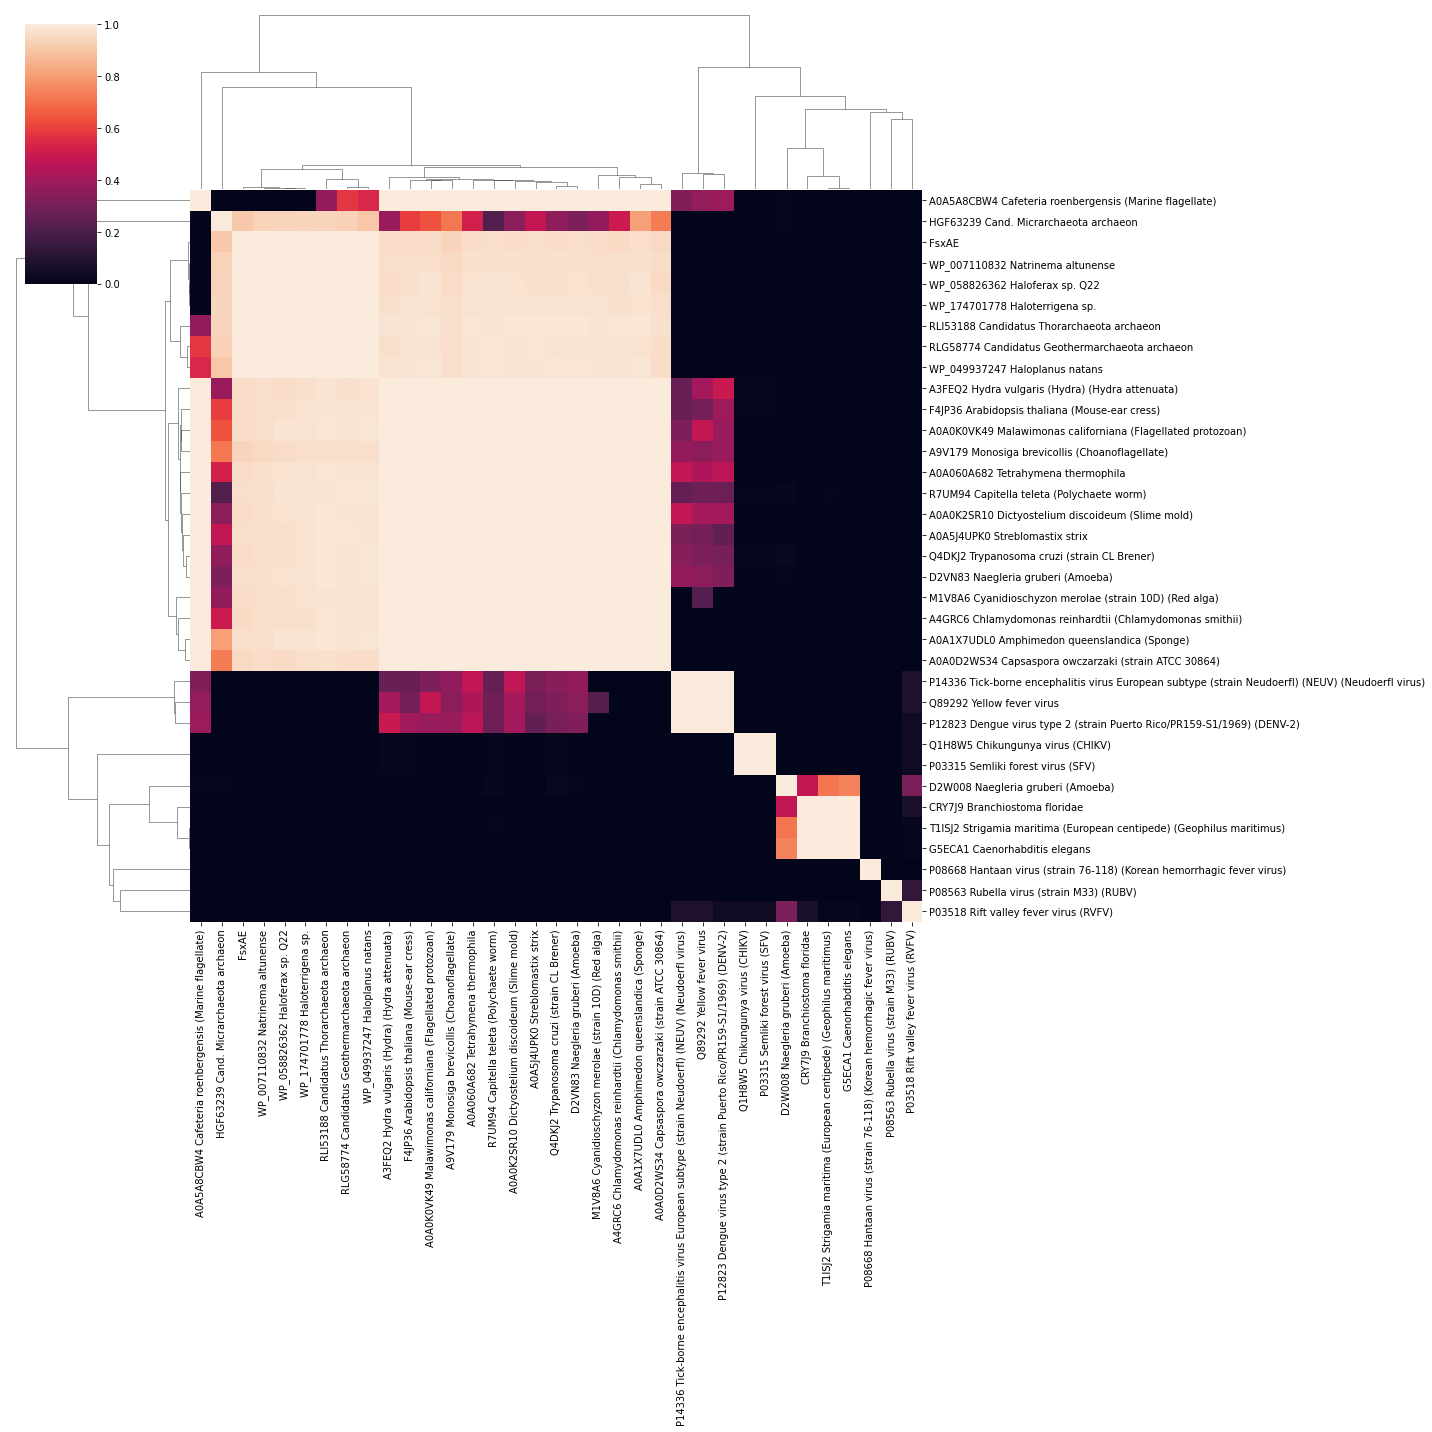

average


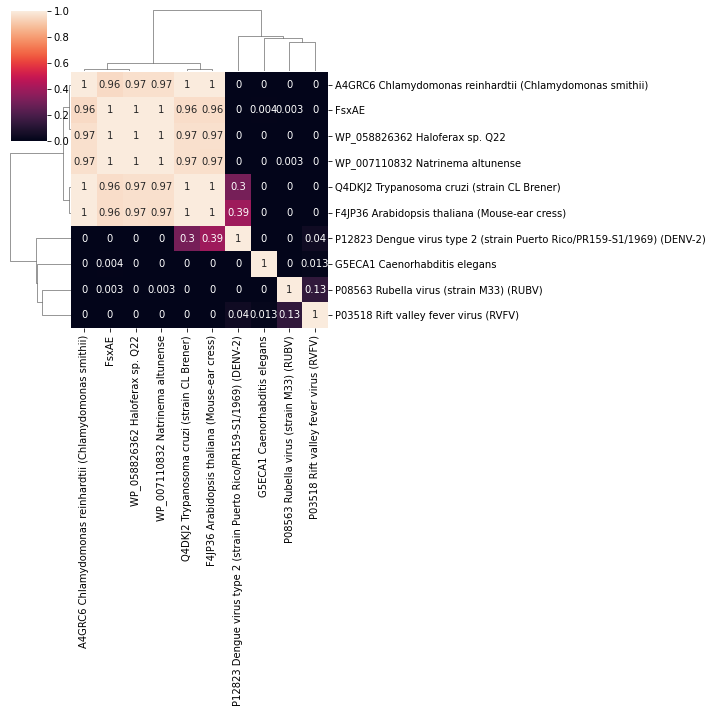

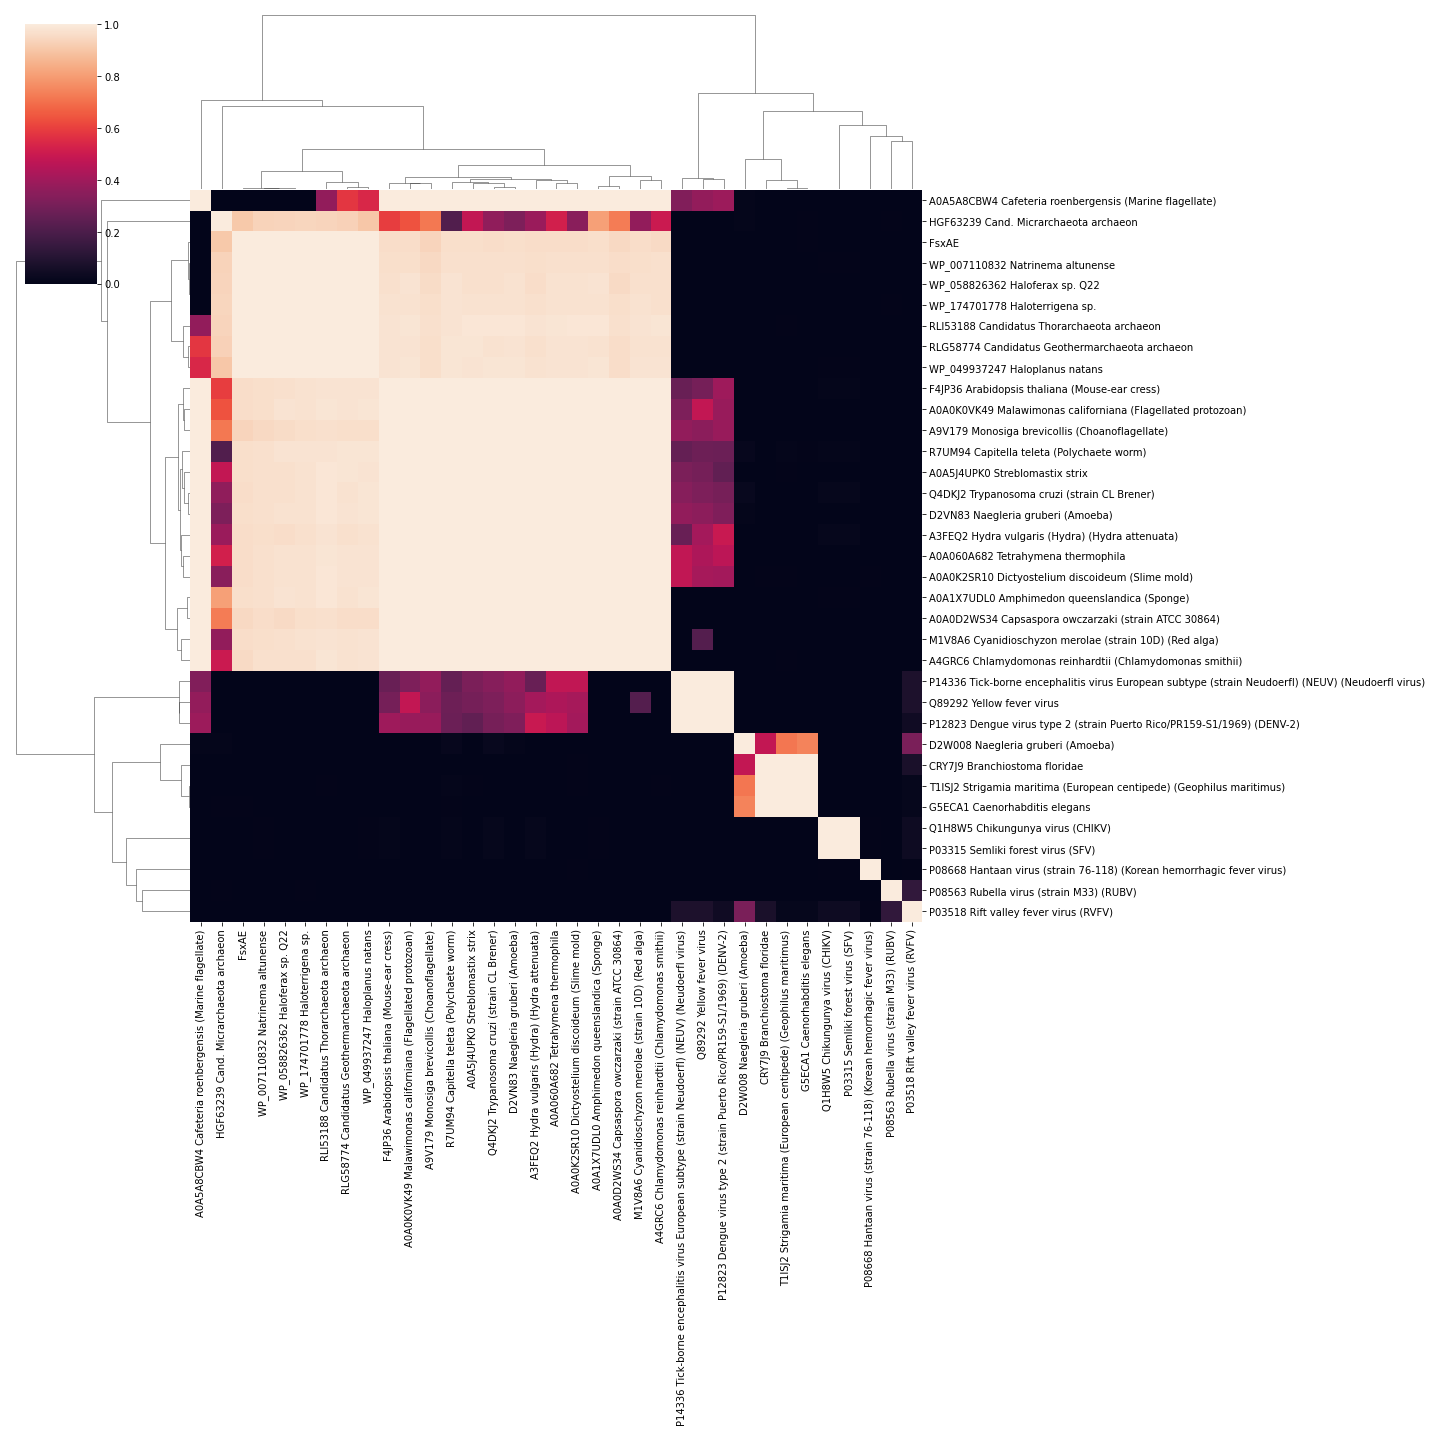

complete


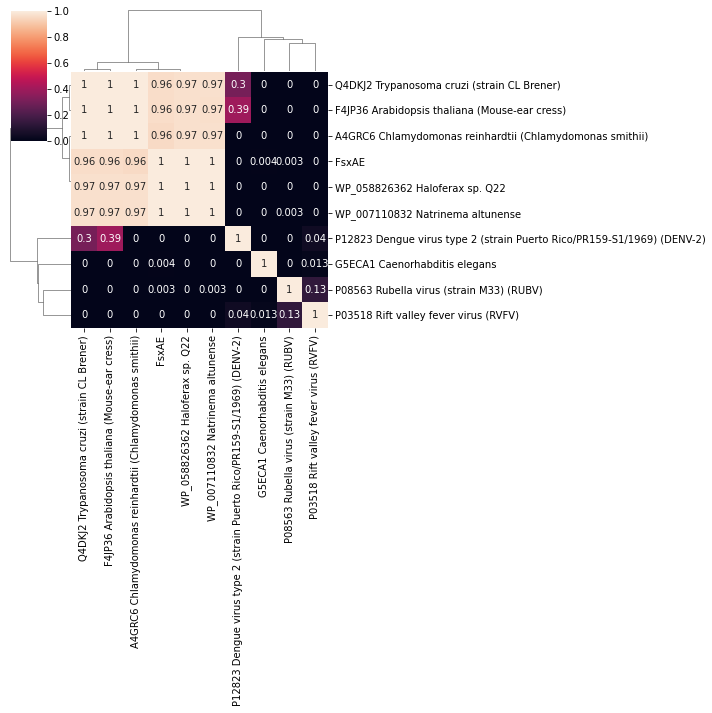

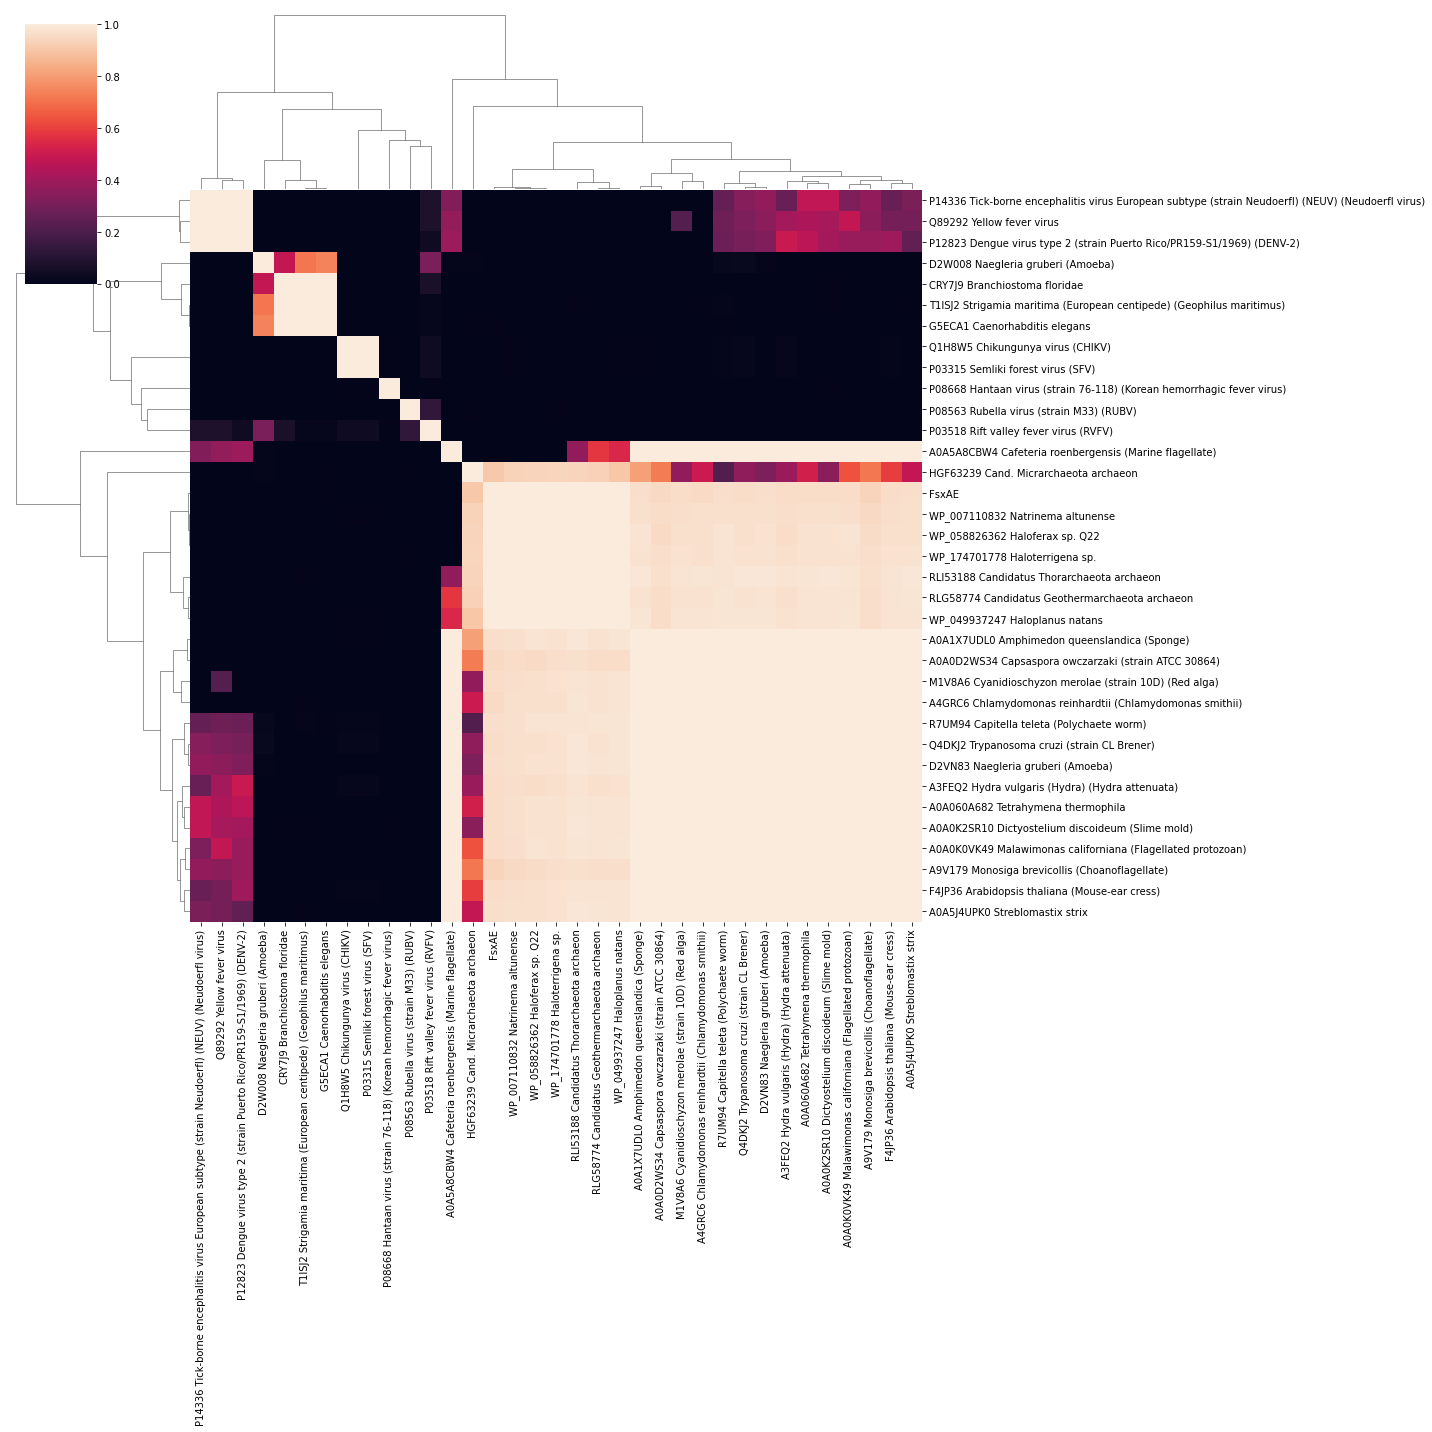

weighted


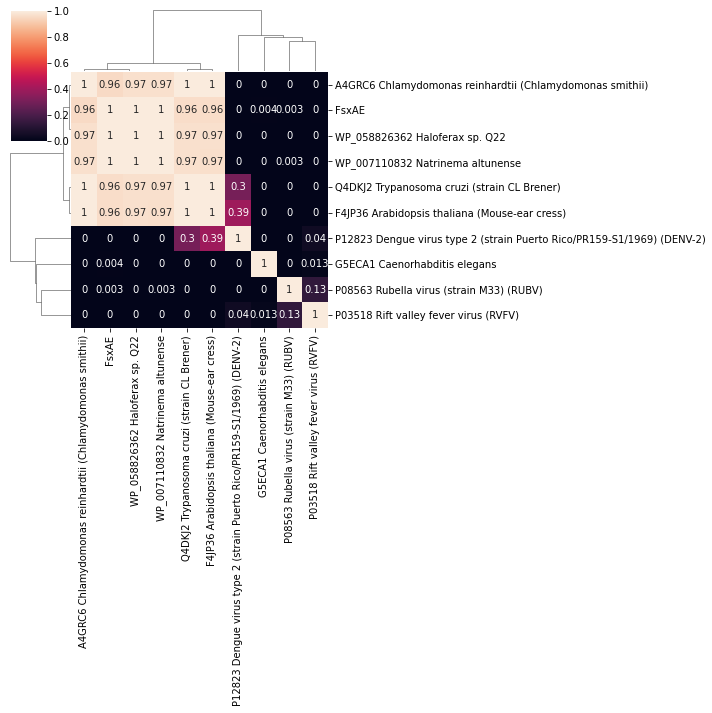

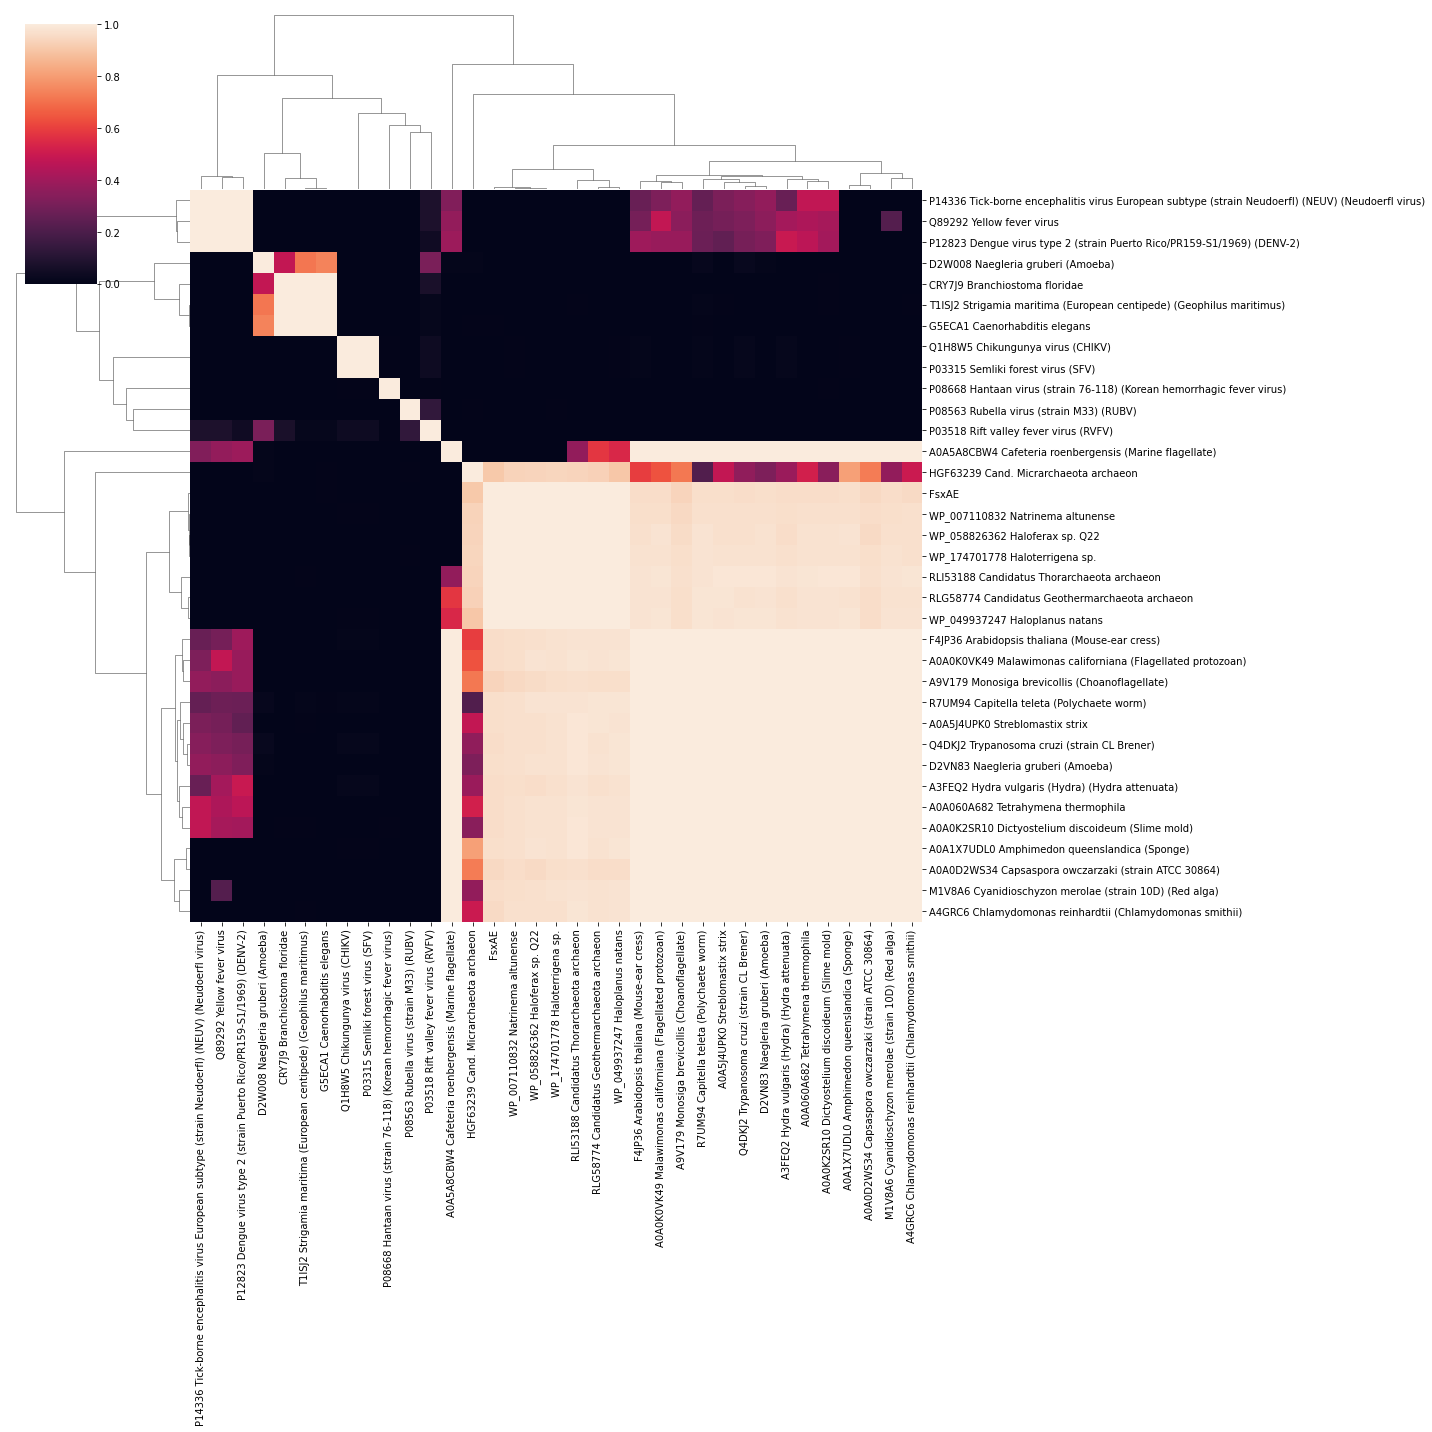

centroid


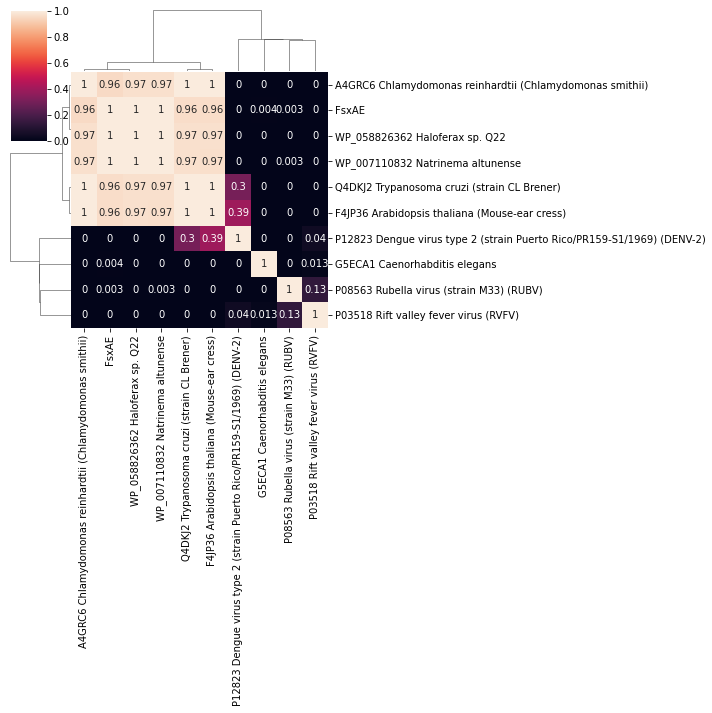

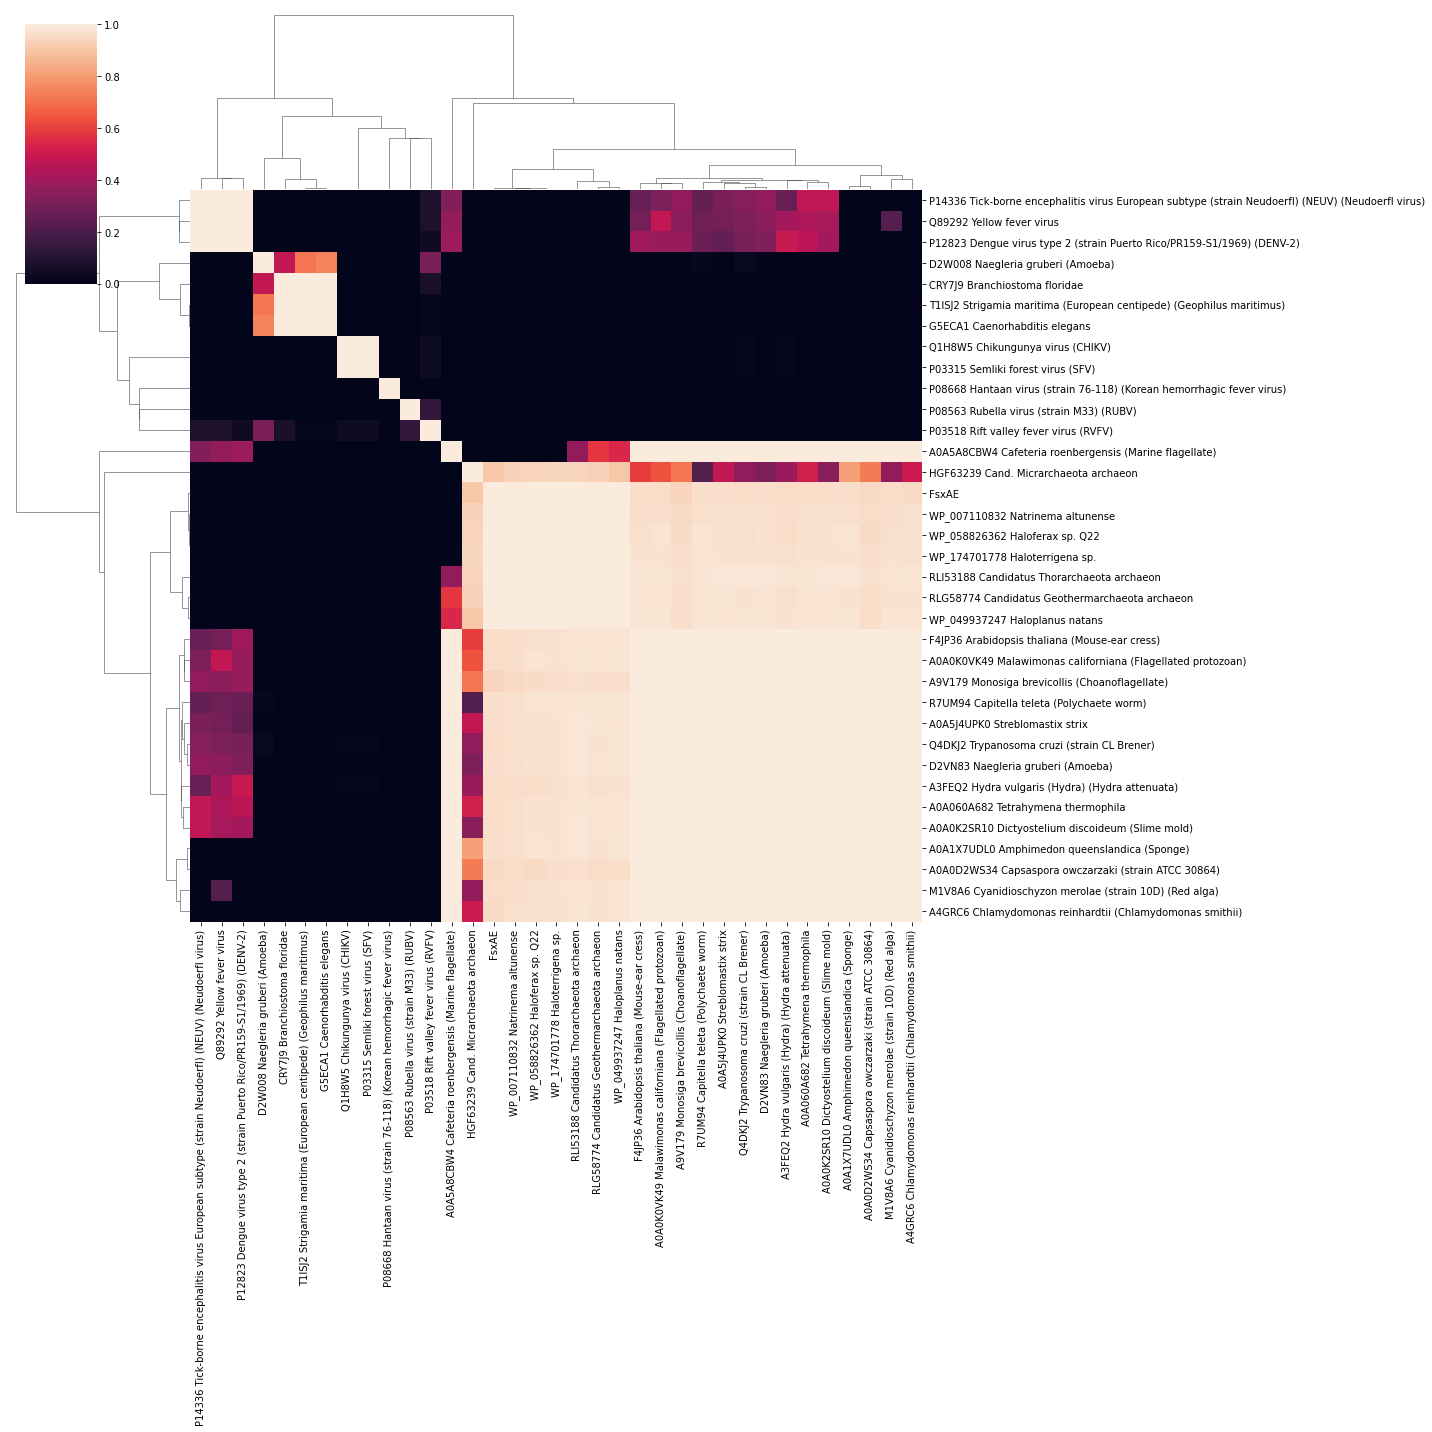

In [18]:
from io import StringIO
import pandas as pd



plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True 

from matplotlib import pyplot as plt
filterDMbig = probaDM[bigindex,:]
filterDMbig= filterDMbig[:,bigindex]
filterDM = probaDM[index,:]
filterDM= filterDM[:,index]

for method in ['single', 'average' , 'complete' , 'weighted' , 'centroid' ]:
    print(method)
    g = sns.clustermap( filterDM , xticklabels=filtername  , yticklabels=filtername , figsize = (10,10) , method = method ,  annot=True )
    g.savefig( method +'profilephylo_fsxa.pdf')
    g.savefig( method +'profilephylo_fsxa.eps')
    
    
    g = sns.clustermap( filterDMbig , xticklabels=bigfiltername  , yticklabels=bigfiltername , figsize = (20,20) , method = method)
    g.savefig( method +'profilephylo_fsxa_big.svg')
    g.savefig( method +'profilephylo_fsxa_big.eps')
    
    plt.show()
    

